# Vision Transformer

[An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929v2)

[Vision Transformer for Small-Size Datasets](https://arxiv.org/pdf/2112.13492.pdf) *todo*

[Training Vision Transformers with Only 2040 Images](https://arxiv.org/abs/2201.10728) *todo*



## Model Notes
* P = patch size
* N = number of patches
* transform image from (H,W,C) to (N,P\*\*2 \*C) where
* also prepend a class token
* LayerNorm
* GeLU activation in MLP layers

## TODO
* fix model always predicting 0

In [1]:
# download pretrained weights for ViT-B/16 model
!wget https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz

--2023-01-14 00:25:32--  https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412815506 (394M) [application/octet-stream]
Saving to: ‘ViT-B_16.npz.1’

ViT-B_16.npz.1      100%[===================>] 393.69M  34.8MB/s    in 13s     

2023-01-14 00:25:47 (29.2 MB/s) - ‘ViT-B_16.npz.1’ saved [412815506/412815506]



In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np

In [18]:
# probably not great just resizing to 224, but also shouldn't just be predicting 0 because of this right?
transforms = T.Compose([T.ToTensor(), T.Resize(224)])
ds = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transforms,
    download=True,
)
dl = DataLoader(
    ds, batch_size=1, shuffle=True,
)

Files already downloaded and verified


In [16]:
# full base ViT
class VisionTransformer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.embedding = nn.Conv2d(3, emb_dim, 16, 16, padding='valid')
        # 197 = (224/16) ** 2
        self.pos_embedding = nn.Parameter(torch.ones(1, 197, emb_dim))
        self.cls = nn.Parameter(torch.ones((1, 1, emb_dim)))
        self.ln = nn.LayerNorm(emb_dim)
        self.emb_dim = emb_dim
        self.encoder = nn.Sequential(*[
            nn.TransformerEncoderLayer(emb_dim, 12, 3072, activation=F.gelu,
                                       batch_first=True) for _ in range(12)
        ])
        self.pre_logits = nn.Linear(emb_dim, emb_dim)
        self.head = nn.Linear(emb_dim, 21843)

    def forward(self, x):
        x = self.embedding(x)
        # (bs, seq_len,emb_dim)
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)
        # prepend class embedding token
        # (bs, 1, emb_dim)
        cls_emb = self.cls + torch.zeros(x.shape[0], 1, 1)
        x = torch.cat((cls_emb, x), dim=1)
        x = self.encoder(x + self.pos_embedding)
        x = self.ln(x)
        x = self.pre_logits(x[:,0])
        x = self.head(x)
        return x

    def load_from_pretrained(self, path):
        with np.load(path) as data:
            params = self.state_dict()
            params['pos_embedding'] = torch.from_numpy(data['Transformer/posembed_input/pos_embedding'])
            params['cls'] = torch.from_numpy(data['cls'])
            params['embedding.weight'] = torch.from_numpy(data['embedding/kernel']).permute(3, 2, 0, 1)
            params['embedding.bias'] = torch.from_numpy(data['embedding/bias'])
            params['ln.weight'] = torch.from_numpy(data['Transformer/encoder_norm/scale'])
            params['ln.bias'] = torch.from_numpy(data['Transformer/encoder_norm/bias'])
            params['pre_logits.weight'] = torch.from_numpy(data['pre_logits/kernel']).T
            params['pre_logits.bias'] = torch.from_numpy(data['pre_logits/bias'])
            params['head.weight'] = torch.from_numpy(data['head/kernel']).T
            params['head.bias'] = torch.from_numpy(data['head/bias'])
            for i in range(12):
                # TODO: issue is probably with attention weights if I had to guess
                #       so will just need to implement manually and then load weights
                q = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/kernel']).reshape(768, -1)
                q_bias = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/bias']).reshape(-1)
                k = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/kernel']).reshape(768, -1)
                k_bias = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/bias']).reshape(-1)
                v = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/kernel']).reshape(768, -1)
                v_bias = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/bias']).reshape(-1)
                params[f'encoder.{i}.self_attn.in_proj_weight'] = torch.cat([q,k, v], dim=1).T
                params[f'encoder.{i}.self_attn.in_proj_bias'] = torch.cat([q_bias, k_bias, v_bias])
                params[f'encoder.{i}.self_attn.out_proj.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/kernel']).reshape(-1, 768)
                params[f'encoder.{i}.self_attn.out_proj.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/bias'])
                params[f'encoder.{i}.linear1.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/kernel']).T
                params[f'encoder.{i}.linear1.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/bias'])
                params[f'encoder.{i}.linear2.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/kernel']).T
                params[f'encoder.{i}.linear2.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/bias'])
                params[f'encoder.{i}.norm1.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_0/scale'])
                params[f'encoder.{i}.norm1.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_0/bias'])
                params[f'encoder.{i}.norm2.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_2/scale']).T
                params[f'encoder.{i}.norm2.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_2/bias'])
            self.load_state_dict(params)

In [206]:
with np.load('ViT-B_16.npz') as data:
    # print(data['embedding/kernel'].shape)
    # print(data['Transformer/posembed_input/pos_embedding'].shape)
    # print(data['pre_logits/kernel'].shape)
    print(data['Transformer/encoderblock_11/MultiHeadDotProductAttention_1/key/kernel'].shape)
    for f in data:
        print(f)

(768, 12, 64)
Transformer/encoder_norm/bias
Transformer/encoder_norm/scale
Transformer/encoderblock_0/LayerNorm_0/bias
Transformer/encoderblock_0/LayerNorm_0/scale
Transformer/encoderblock_0/LayerNorm_2/bias
Transformer/encoderblock_0/LayerNorm_2/scale
Transformer/encoderblock_0/MlpBlock_3/Dense_0/bias
Transformer/encoderblock_0/MlpBlock_3/Dense_0/kernel
Transformer/encoderblock_0/MlpBlock_3/Dense_1/bias
Transformer/encoderblock_0/MlpBlock_3/Dense_1/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/value/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/

tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])


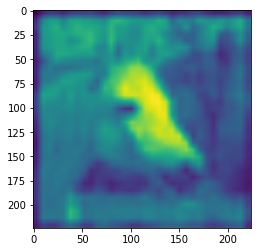

In [23]:
import matplotlib.pyplot as plt

model = VisionTransformer(768)
model.load_from_pretrained('ViT-B_16.npz')
model.eval()
for (i, (x, _)) in enumerate(dl):
    plt.imshow(x.squeeze(0)[0])
    if i > 4: break
    out = model(x)
    cls = torch.argmax(out, dim=1)
    print(cls)


In [ ]:
m_dict = model.state_dict()
for p in m_dict:
    print(p)

pos_embedding
cls
embedding.weight
embedding.bias
ln.weight
ln.bias
encoder.0.self_attn.in_proj_weight
encoder.0.self_attn.in_proj_bias
encoder.0.self_attn.out_proj.weight
encoder.0.self_attn.out_proj.bias
encoder.0.linear1.weight
encoder.0.linear1.bias
encoder.0.linear2.weight
encoder.0.linear2.bias
encoder.0.norm1.weight
encoder.0.norm1.bias
encoder.0.norm2.weight
encoder.0.norm2.bias
encoder.1.self_attn.in_proj_weight
encoder.1.self_attn.in_proj_bias
encoder.1.self_attn.out_proj.weight
encoder.1.self_attn.out_proj.bias
encoder.1.linear1.weight
encoder.1.linear1.bias
encoder.1.linear2.weight
encoder.1.linear2.bias
encoder.1.norm1.weight
encoder.1.norm1.bias
encoder.1.norm2.weight
encoder.1.norm2.bias
encoder.2.self_attn.in_proj_weight
encoder.2.self_attn.in_proj_bias
encoder.2.self_attn.out_proj.weight
encoder.2.self_attn.out_proj.bias
encoder.2.linear1.weight
encoder.2.linear1.bias
encoder.2.linear2.weight
encoder.2.linear2.bias
encoder.2.norm1.weight
encoder.2.norm1.bias
encoder.2.